In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import requests
import io


In [9]:

# Display and plotting defaults
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load dataset from Hugging Face - direct CSV download
# Using direct download to avoid glob pattern issues with datasets library
url = "https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/resolve/main/dataset.csv"
print("Downloading dataset from Hugging Face...")
response = requests.get(url, timeout=30)
response.raise_for_status()
df = pd.read_csv(io.StringIO(response.text))
print("Dataset loaded successfully!")

# Basic cleaning: drop obvious duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)

print(f"\nDataset shape: {df.shape}")
print(f"Number of columns: {len(df.columns)}")
print(f"Column names: {list(df.columns)}")
print("\nFirst few rows:")
df.head()


Dataset loaded successfully!

Dataset shape: (114000, 21)
Number of columns: 21
Column names: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

First few rows:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [10]:
# Prepare numeric features for PCA and clustering
# Select audio features that are numeric and relevant for analysis
num_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

available = [c for c in num_features if c in df.columns]
missing = sorted(set(num_features) - set(available))
if missing:
    print('Missing columns skipped:', missing)

# Keep rows with no NaNs in used columns
model_df = df.dropna(subset=available).copy()

X = model_df[available].copy()

print(f"Features used: {available}")
print(f"Data shape after cleaning: {X.shape}")
print(f"\nFeature statistics:")
X.describe()


Features used: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Data shape after cleaning: (114000, 10)

Feature statistics:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,1.140000e+05
mean,0.566800,0.641383,-8.258960,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,2.280292e+05
std,0.173542,0.251529,5.029337,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,1.072977e+05
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,1.740660e+05
50%,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,2.129060e+05
75%,0.695000,0.854000,-5.003000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,2.615060e+05
max,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.237295e+06


## Interpreting Mean Danceability and Variability

### What we are measuring

In this dataset, **`danceability`** is a continuous audio feature (0 to 1) that reflects how suitable a track is for dancing based on musical elements (e.g., tempo stability, beat strength, and rhythmic regularity).

### What “mean” vs “variability” means

- **Mean danceability** answers: *On average, how danceable are the tracks in a group (overall / within a genre / within a cluster)?*
- **Danceability variability** answers: *How diverse are the tracks in that group?*
  - A **higher standard deviation** means the group contains both low- and high-danceability songs (more diverse).
  - A **lower standard deviation** means the group is more consistent in danceability.

### Why this is useful for our problem

Interpreting **mean + variability together** helps us avoid misleading conclusions. Two groups can have similar average danceability, but very different variability—meaning one group is homogeneous while the other mixes very different styles. This matters for **segmenting songs**, **understanding genre breadth**, and **building recommendations** (consistent “vibes” vs diverse playlists).



In [ ]:
# Quantify overall danceability mean + variability

dance_mean = model_df['danceability'].mean()
dance_std = model_df['danceability'].std()
dance_var = model_df['danceability'].var()

print("Overall Danceability Summary")
print("-" * 35)
print(f"Mean: {dance_mean:.4f}")
print(f"Std:  {dance_std:.4f}")
print(f"Var:  {dance_var:.4f}")

# Danceability mean + variability by genre (filter small groups)
min_n = 200
genre_stats = (
    model_df.groupby('track_genre', dropna=False)['danceability']
    .agg(['count', 'mean', 'std'])
    .rename(columns={'count': 'n'})
    .query('n >= @min_n')
    .sort_values('mean')
)

print(f"\nDanceability by Genre (n >= {min_n})")
print("-" * 35)
print("Lowest-mean genres:")
print(genre_stats.head(10).round(3))
print("\nHighest-mean genres:")
print(genre_stats.tail(10).round(3))

# Visualize distribution + most/least variable genres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(model_df['danceability'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Danceability Distribution (All Tracks)')
axes[0].set_xlabel('danceability')
axes[0].set_ylabel('count')

most_variable = genre_stats.sort_values('std', ascending=False).head(10)
least_variable = genre_stats.sort_values('std', ascending=True).head(10)

plot_df = pd.concat([
    most_variable.assign(group='Most variable (std)'.title()),
    least_variable.assign(group='Least variable (std)'.title())
]).reset_index(names='track_genre')

sns.barplot(data=plot_df, y='track_genre', x='std', hue='group', ax=axes[1])
axes[1].set_title('Genre Danceability Variability (Std)')
axes[1].set_xlabel('std(danceability)')
axes[1].set_ylabel('track_genre')
axes[1].legend(title='')

plt.tight_layout()
plt.show()



## Part 1: Principal Component Analysis (PCA)


In [11]:
# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA - keep all components to analyze variance
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Explained variance ratio per component:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}%)")

print(f"\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance, 1):
    print(f"PC1-PC{i}: {cum_var:.4f} ({cum_var*100:.2f}%)")


Explained variance ratio per component:
PC1: 0.2874 (28.74%)
PC2: 0.1524 (15.24%)
PC3: 0.1234 (12.34%)
PC4: 0.0971 (9.71%)
PC5: 0.0887 (8.87%)
PC6: 0.0834 (8.34%)
PC7: 0.0748 (7.48%)
PC8: 0.0463 (4.63%)
PC9: 0.0325 (3.25%)
PC10: 0.0140 (1.40%)

Cumulative explained variance:
PC1-PC1: 0.2874 (28.74%)
PC1-PC2: 0.4398 (43.98%)
PC1-PC3: 0.5632 (56.32%)
PC1-PC4: 0.6603 (66.03%)
PC1-PC5: 0.7490 (74.90%)
PC1-PC6: 0.8323 (83.23%)
PC1-PC7: 0.9071 (90.71%)
PC1-PC8: 0.9535 (95.35%)
PC1-PC9: 0.9860 (98.60%)
PC1-PC10: 1.0000 (100.00%)


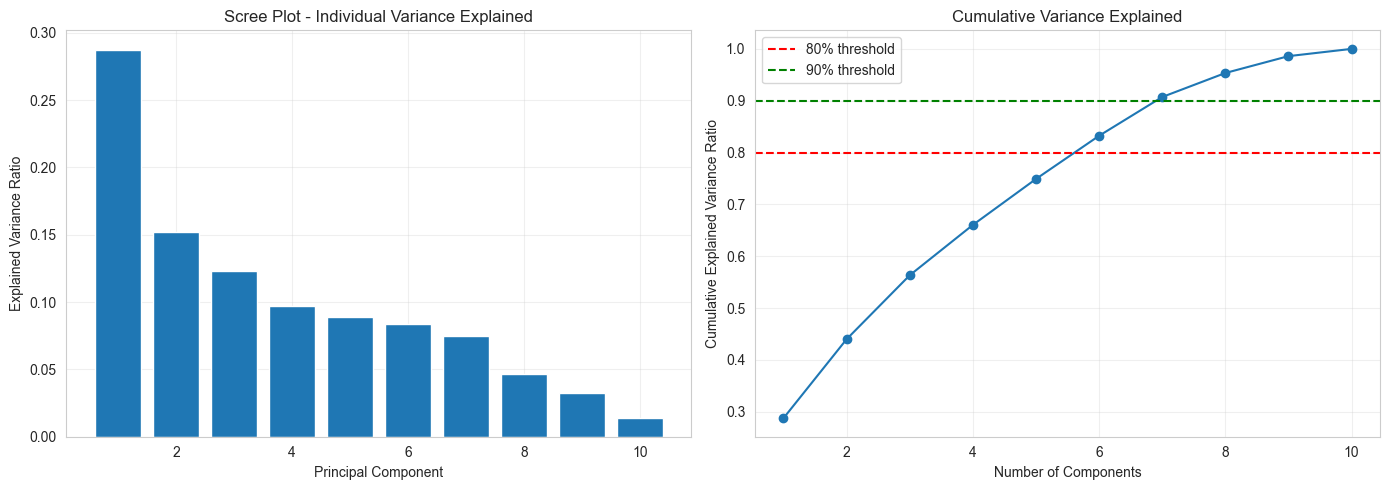


Components needed for 80% variance: 6
Components needed for 90% variance: 7


In [12]:
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance explained
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot - Individual Variance Explained')
axes[0].grid(True, alpha=0.3)

# Cumulative variance explained
axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, marker='o')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='g', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance Ratio')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for common thresholds
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nComponents needed for 80% variance: {n_80}")
print(f"Components needed for 90% variance: {n_90}")


## Part 2: Clustering (K-Means)


Using sample of 10000 points for faster computation...
Testing different k values...
  Testing k=2... silhouette=0.2430
  Testing k=3... silhouette=0.1588
  Testing k=4... silhouette=0.1672
  Testing k=5... silhouette=0.1664
  Testing k=6... silhouette=0.1763
  Testing k=7... silhouette=0.1844
  Testing k=8... silhouette=0.1598
  Testing k=9... silhouette=0.1632
  Testing k=10... silhouette=0.1668
  Testing k=11... silhouette=0.1653
  Testing k=12... silhouette=0.1462
  Testing k=13... silhouette=0.1514
  Testing k=14... silhouette=0.1454
  Testing k=15... silhouette=0.1453


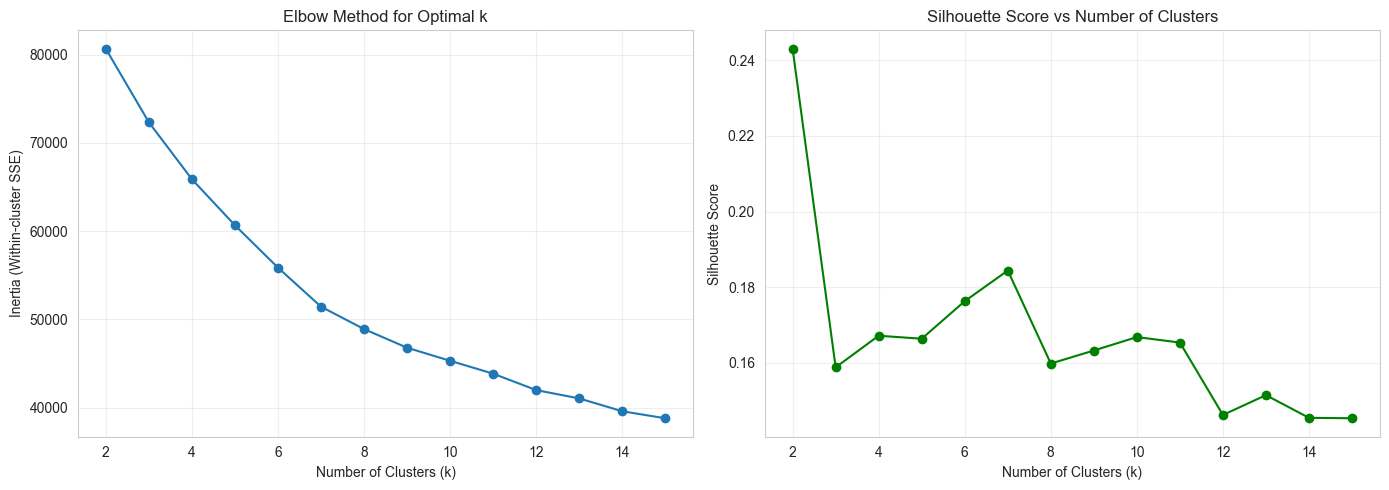

Optimal number of clusters (highest silhouette score): k = 2
Silhouette score at k=2: 0.2430


In [14]:
# Determine optimal number of clusters using elbow method
# Use a sample for faster computation when finding optimal k
sample_size = min(10000, len(X_scaled))
if sample_size < len(X_scaled):
    print(f"Using sample of {sample_size} points for faster computation...")
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
else:
    X_sample = X_scaled

# Test k from 2 to 15
k_range = range(2, 16)
inertias = []
silhouette_scores = []

print("Testing different k values...")
for k in k_range:
    print(f"  Testing k={k}...", end=' ')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)  # Reduced n_init for speed
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    # Use sample_size parameter to speed up silhouette calculation
    sil_score = silhouette_score(X_sample, kmeans.labels_, sample_size=min(5000, len(X_sample)))
    silhouette_scores.append(sil_score)
    print(f"silhouette={sil_score:.4f}")

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster SSE)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='o', color='green')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (highest silhouette score): k = {optimal_k}")
print(f"Silhouette score at k={optimal_k}: {max(silhouette_scores):.4f}")


In [15]:
# Apply K-Means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
model_df['cluster'] = cluster_labels

# Calculate clustering evaluation metrics
silhouette = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)

print("Clustering Evaluation Metrics:")
print(f"Silhouette Score: {silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f} (higher is better)")

print(f"\nCluster sizes:")
print(model_df['cluster'].value_counts().sort_index())


Clustering Evaluation Metrics:
Silhouette Score: 0.2508 (higher is better, range: -1 to 1)
Davies-Bouldin Index: 1.6517 (lower is better)
Calinski-Harabasz Index: 27345.0761 (higher is better)

Cluster sizes:
cluster
0    27916
1    86084
Name: count, dtype: int64


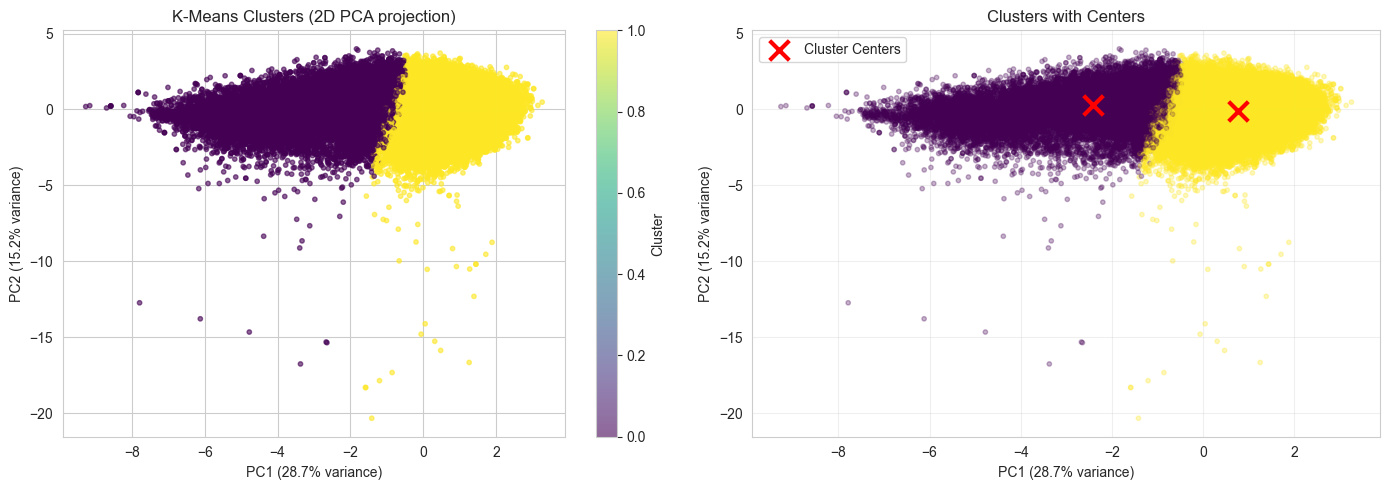

In [16]:
# Visualize clusters using first two principal components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot colored by cluster
scatter = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=cluster_labels, cmap='viridis', alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('K-Means Clusters (2D PCA projection)')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster centers in PCA space
cluster_centers_pca = pca_2d.transform(kmeans_final.cluster_centers_)
axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                c=cluster_labels, cmap='viridis', alpha=0.3, s=10)
axes[1].scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[1].set_title('Clusters with Centers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Cluster characteristics (mean values):
         danceability  energy  loudness  speechiness  acousticness  \
cluster                                                              
0               0.471   0.304   -14.146        0.058         0.743   
1               0.598   0.751    -6.350        0.093         0.176   

         instrumentalness  liveness  valence    tempo  duration_ms  
cluster                                                             
0                   0.299     0.178    0.318  110.158   218611.338  
1                   0.110     0.225    0.525  126.036   231083.237  


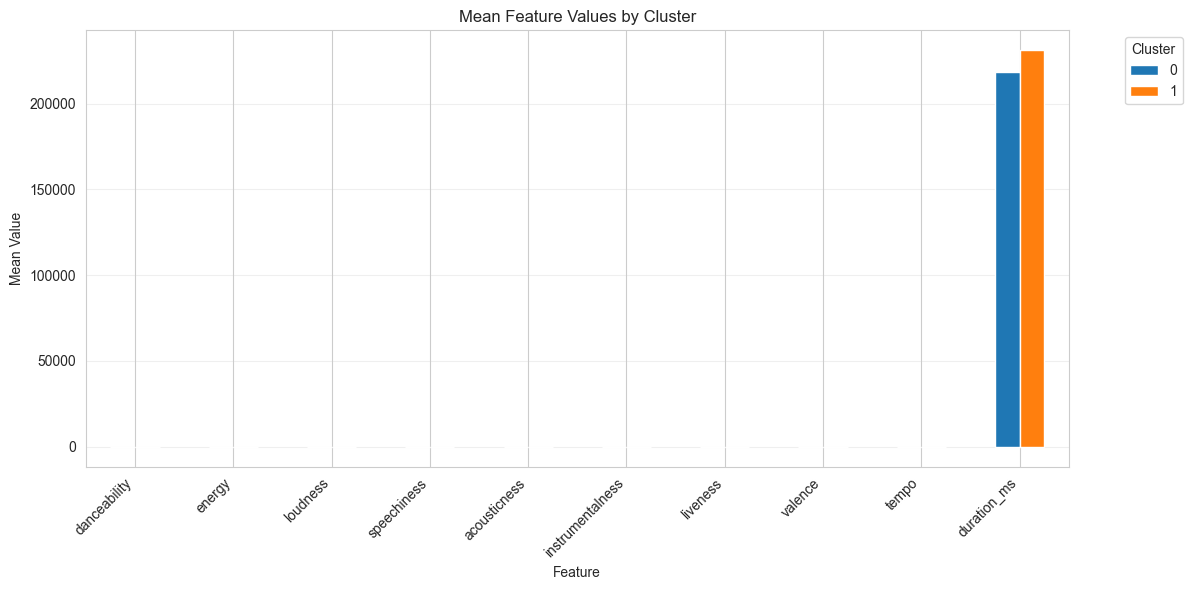

In [ ]:
# Analyze cluster characteristics (mean + variability)
print("Cluster characteristics (mean values):")
cluster_means = model_df.groupby('cluster')[available].mean()
print(cluster_means.round(3))

print("\nCluster characteristics (std / variability):")
cluster_stds = model_df.groupby('cluster')[available].std()
print(cluster_stds.round(3))

# Quick, targeted interpretation for danceability variability
if 'danceability' in available:
    dance_cluster = (
        model_df.groupby('cluster')['danceability']
        .agg(['count', 'mean', 'std'])
        .rename(columns={'count': 'n'})
    )
    print("\nDanceability by Cluster (mean + std):")
    print(dance_cluster.round(3))

# Visualize cluster means
fig, ax = plt.subplots(figsize=(12, 6))
cluster_means.T.plot(kind='bar', ax=ax)
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Value')
ax.set_title('Mean Feature Values by Cluster')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Explanation: How PCA is Used in the Project

### Task description

We applied **PCA (Principal Component Analysis)** to the 10 standardized Spotify audio features to **reduce dimensionality** and **identify the main axes of variation** in the dataset.

### What PCA showed on our data

- **Variance captured**: In our run, we needed **6 components** to reach ~**80%** cumulative explained variance and **7 components** to reach ~**90%**. This means a large portion of the information in 10 features can be summarized with fewer “combined” features.
- **Interpretability**: The loadings/components represent *combinations* of original features. For example, a leading component often behaves like an **energy–danceability** direction (high energy + high danceability vs. low energy + low danceability), while another can behave like an **acoustic–instrumental** direction.

### Why PCA is a good fit for this problem

- **Visualization**: It makes the dataset easier to visualize (e.g., projecting to 2D/3D) to inspect structure.
- **Noise reduction**: By focusing on top components, PCA de-emphasizes small-variance directions that are often noise.
- **Better clustering/recommendation**: PCA can be used as a preprocessing step for clustering to help segment songs by broad musical “dimensions.”


## Explanation: How Clustering is Used in the Project

### Task description

We applied **K-Means clustering** to the standardized audio-feature space to discover **unsupervised groupings** of similar songs (i.e., segmentation based on audio characteristics rather than labels).

### How we chose the method and hyperparameter (k)

- **Algorithm**: K-Means (fast, scalable, and a strong baseline for continuous, standardized features).
- **Choosing k**: We evaluated **k = 2 to 15** using:
  - **Elbow/Inertia** (within-cluster SSE; lower is better, but the elbow can be subjective)
  - **Silhouette score** (higher is better; measures cohesion vs separation)

In our run, the **best silhouette score occurred at k = 2**, so we used **2 clusters**.

### How we evaluated clustering quality (our results)

Using the full dataset, we reported:
- **Silhouette score ≈ 0.2508** (modest separation; indicates overlap but some structure)
- **Davies–Bouldin ≈ 1.6517** (lower is better; moderate)
- **Calinski–Harabasz ≈ 27345** (higher is better; indicates separable structure at this k)

### Why K-Means + PCA visualization is a good fit for this problem

- The goal is **structure discovery/segmentation** (no ground-truth labels required).
- **K-Means** produces interpretable cluster centroids we can summarize using **mean + variability** of features (including danceability).
- **PCA (2D projection)** provides a clear visualization of how clusters overlap/separate, which helps explain *why* the segmentation is (or isn’t) strong.

Overall, PCA + clustering gave us a compact way to both **reduce dimensionality** and **group songs into broad audio profiles** (e.g., more acoustic/low-energy vs higher-energy/danceable), which is directly useful for similarity-based exploration and recommendations.
